In [5]:
import fastpli.model.solver
import fastpli.model.sandbox
import fastpli.io
import fastpli.model.sandbox as sandbox

import os

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

def set_3d_axes_equal(ax):
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    plot_radius = 0.5 * max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

def plot_fiber_bundles(fbs, colors):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    for fb, c in zip(fbs, colors):
        for f in fb:
            plt.plot(f[:,0],f[:,1],f[:,2], c)
    set_3d_axes_equal(ax)

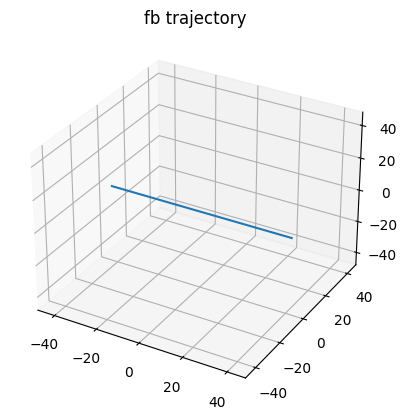

In [6]:
#Single Fibre Bungle

t = np.linspace(0, 4 * np.pi, 100, True)
traj = np.array((42 * np.cos(t), 42 * np.sin(t), 10 * t)).T

xmin, xmax = traj[:,0].min(), traj[:,0].max()

# create a new trajectory with the same number of points as the original
t_new = np.linspace(0, 1, len(t), True)
traj_new = np.array((xmin + (xmax-xmin)*t_new, np.zeros_like(t_new), np.ones_like(t_new)*traj[0,2])).T

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot(
    traj_new[:, 0],
    traj_new[:, 1],
    traj_new[:, 2],
)
plt.title("fb trajectory")
set_3d_axes_equal(ax)
plt.show()

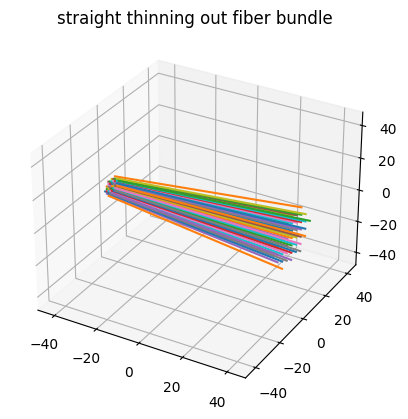

In [11]:
seeds = sandbox.seeds.triangular_grid(width=42,
                                      height=42,
                                      spacing=6,
                                      center=True)
radius = 21
circ_seeds = sandbox.seeds.crop_circle(radius=radius, seeds=seeds)
#populating fiber bundle
fiber_bundle = sandbox.build.bundle(
    traj=traj_new,
    seeds=circ_seeds,
    radii=np.random.uniform(0.1, 0.1, circ_seeds.shape[0]),
    scale=0.25 + 0.5 * np.linspace(0, 1, traj.shape[0]))

# plotting
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
for fiber in fiber_bundle:
    ax.plot(fiber[:, 0], fiber[:, 1], fiber[:, 2])
plt.title("straight thinning out fiber bundle")
set_3d_axes_equal(ax)
plt.show()

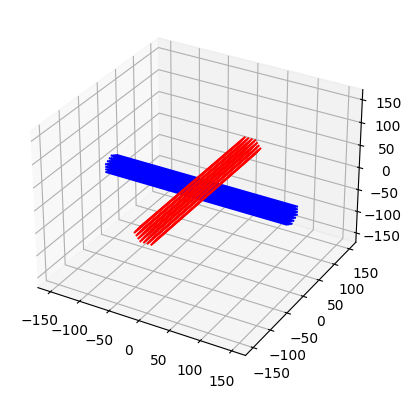

In [51]:
solver = fastpli.model.solver.Solver()

fiber_bundle_trj_x = [[-150, 0, 0], [150, 0, 0]]
fiber_bundle_trj_y = [[0, -150, 0], [0, 150, 0]]

population = fastpli.model.sandbox.seeds.triangular_circle(20, 6)



fiber_radii = np.random.uniform(2.0,2.0, population.shape[0])
fiber_bundle_x = fastpli.model.sandbox.build.bundle(fiber_bundle_trj_x,
                                                    population, fiber_radii)

fiber_radii = np.random.uniform(2.0, 2.0, population.shape[0])
fiber_bundle_y = fastpli.model.sandbox.build.bundle(fiber_bundle_trj_y,
                                                    population, fiber_radii)

fiber_bundles = [fiber_bundle_x, fiber_bundle_y]

plot_fiber_bundles(fiber_bundles, ['b', 'r'])
plt.show()

solved: 284, 5009/0


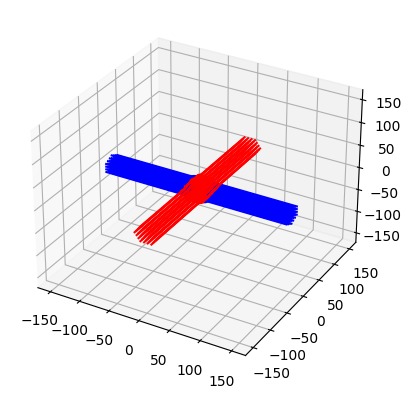

In [21]:
# run solver
solver.fiber_bundles = fiber_bundles
solver.obj_min_radius = 4
solver.obj_mean_length = 4

N = 1000
for i in range(N):
    solved = solver.step()
    if solved:
        break
    print(f'{i/N*100:.2f}%', end='\r')
print(f'solved: {i}, {solver.num_obj}/{solver.num_col_obj}')

plot_fiber_bundles(solver.fiber_bundles, ['b', 'r'])
plt.show()


**add a random displacement to each fiber point (fiber[:,:2]) to add variability to the model**

(2, 4)
(9, 4)


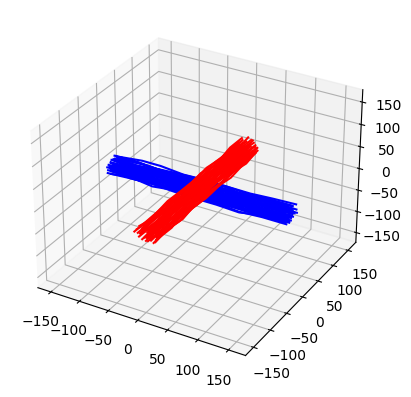

solved: 839, 750/0


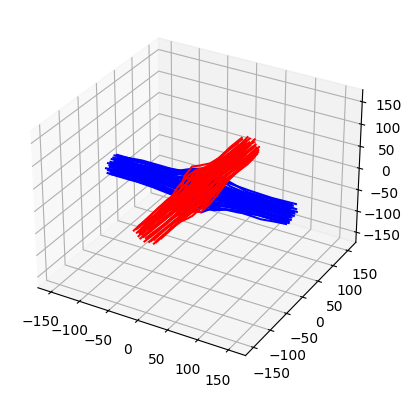

In [52]:
# run solver
solver.fiber_bundles = fiber_bundles
solver.obj_min_radius = 10
solver.obj_mean_length = 30
solver.apply_boundary_conditions(n_max=10)
print(fiber_bundles[0][0].shape)
print(solver.fiber_bundles[0][0].shape)

fbs = solver.fiber_bundles
for i, fb in enumerate(fbs):
    for j, _ in enumerate(fb):
        fbs[i][j][:,:3] += np.random.uniform(-1,5,(fbs[i][j].shape[0],3))
        fbs[i][j][:,3] *= np.random.uniform(0.5,2,(fbs[i][j].shape[0]))
plot_fiber_bundles(fbs, ['b', 'r'])
plt.show()

N = 1000
solver.fiber_bundles = fbs
for i in range(N):
    solved = solver.step()
    if solved:
        break
    print(f'{i/N*100:.2f}%', end='\r')
print(f'solved: {i}, {solver.num_obj}/{solver.num_col_obj}')

plot_fiber_bundles(solver.fiber_bundles, ['b', 'r'])
plt.show()


In [53]:
fastpli.io.fiber_bundles.save('crossing_offset.dat', solver.fiber_bundles, mode='w')

**What behavior do you observe between both models?**
Adding random displacement to the fibers before running the solver can introduce more variability in the model, making it more realistic and potentially leading to more accurate results. On the other hand, not adding displacement can result in a less realistic model with less variability.

However, adding too much displacement can lead to unrealistic and unstable fiber bundles, which can affect the solver's ability to converge to a solution. Therefore, it is important to strike a balance between introducing enough variability and maintaining the stability of the fiber bundles.

In summary, adding displacement can lead to a more realistic and variable model, but it needs to be carefully balanced to avoid instability and ensure that the solver can converge to a solution.